In [1]:
library(ggplot2)
library(reshape2)
library(dplyr)
library(stringr)
theme_set(theme_bw())
options(repr.plot.width=7, repr.plot.height=4)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



# Introduction

![classical interaction structure](figures/3d-interactions-oliva.png)

We would like to examine and tabulate frequencies of tertiary interactions across our tRNA set. [Oliva et al. 2006](10.1093/nar/gkj491) has this as Table 1: ![classical interaction table](figures/3d-table.png)

The 18G-55U line is troubling, since it doesn't seem to correspond to the Sprinzl 2004 dataset they used to quantify
frequencies. We'll leave it alone for now, and go through all of the other interactions.

In [2]:
identities = read.delim('identities.tsv', sep='\t')
identities$quality = as.logical(identities$quality)
identities$restrict = as.logical(identities$restrict)

# Tertiary interaction frequencies

## 8-14-21

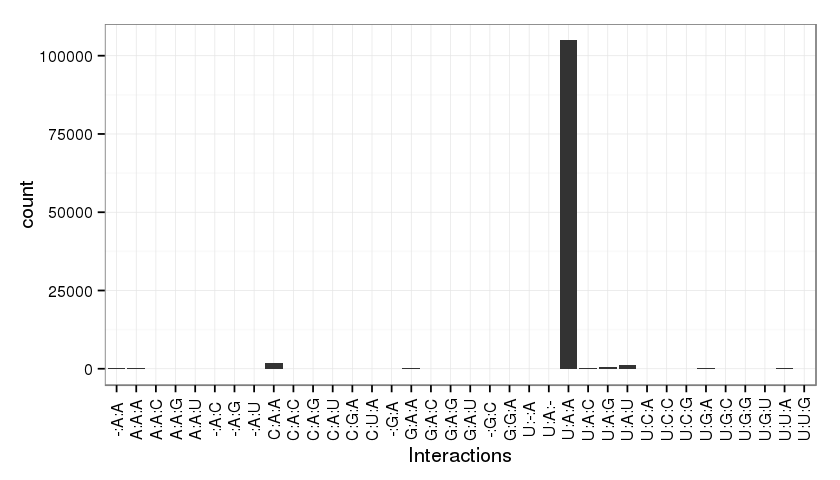

In [3]:
df = identities
df$Interactions = paste0(df$X8, ':', df$X14, ':', df$X21)
ggplot(df, aes(x=Interactions)) + geom_histogram() + theme(axis.text.x=element_text(angle=90, vjust=0.5))

Do these relative frequencies hold if we restrict by species and quality set?

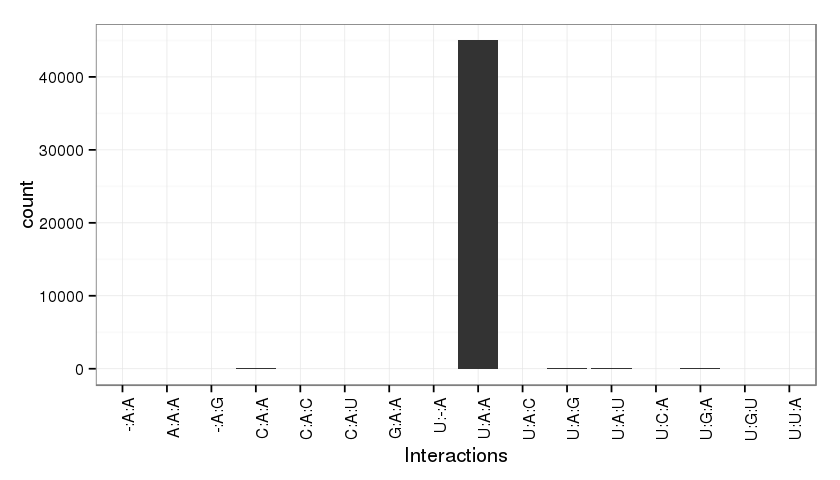

In [4]:
ggplot(df[!df$restrict & df$quality, ], aes(x=Interactions)) + geom_bar() + theme(axis.text.x = element_text(angle = 90, hjust = 1))

The ratio of U:A:A to the other possibilities shrinks a bit, though it's hard to quantify by how much. Which isotypes are responsible for noncanonical base pairs?

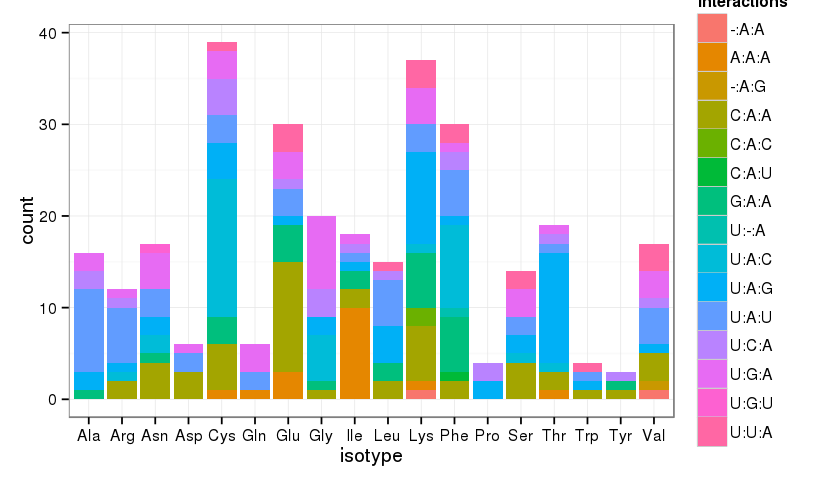

In [5]:
ggplot(df[df$Interactions != 'U:A:A' & !df$restrict & df$quality, ], aes(x=isotype, fill=Interactions)) + geom_bar()

For the most part, it seems that 8-14-21 base combinations are distributed evenly across different isotypes. One exception to this is A:A:A, which seems to be enriched in isoleucine. If it's concentrated in one species, then it's probably a single tRNA amplified sequence, so the scores would be either identical (recent amplification) or very similar.

In [6]:
print(table(droplevels(df[df$Interactions == 'A:A:A' & !df$restrict & df$quality & df$isotype == "Ile", c("species_long", "score")])))

                                                           score
species_long                                                71.9 72.3
  Danio rerio (Zebrafish Sep. 2014 GRCz10/danRer10)            0    1
  Gasterosteus aculeatus (stickleback) (Broad 1.0 Feb 2006)    9    0


What if the score distribution was different between tRNAs with the U:A:A interaction and tRNAs with different bases at 8-14-21? The t-test is useful for looking at differences between score distributions.


	Welch Two Sample t-test

data:  df[df$Group == "U:A:A" & df$quality & !df$restrict, ]$score and df[df$Group != "U:A:A" & df$quality & !df$restrict, ]$score
t = 22.213, df = 313.21, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 7.576375 9.048992
sample estimates:
mean of x mean of y 
 72.69412  64.38143 



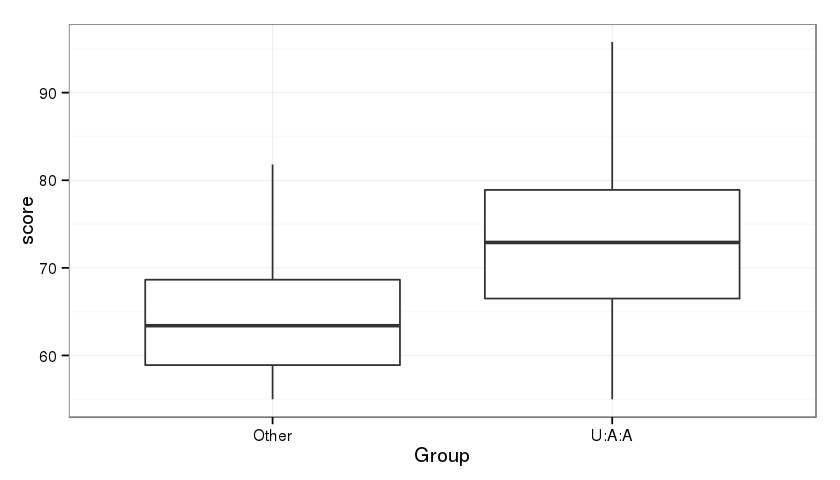

In [7]:
df$Group = ifelse(df$Interactions == "U:A:A", "U:A:A", "Other")
print(t.test(df[df$Group == "U:A:A" & df$quality & !df$restrict, ]$score, df[df$Group != "U:A:A" & df$quality & !df$restrict, ]$score))
ggplot(df[df$quality & !df$restrict, ], aes(x=Group, y=score)) + geom_boxplot()

The distribution is indeed different, both among the quality restricted set and the entire set (not shown). Maybe we should check for this interaction in the future.

Next, I'd like to look at the correlation between isotype and base triples. My hypothesis is that the enriched base triples in isotypes (e.g. A:A:A in Ile) are the product of random amplification. I'll use a $\chi$-squared test for this.

In [8]:
chisq.test(table(df[!df$restrict & df$quality, ]$Interactions, droplevels(df[!df$restrict & df$quality, ]$isotype)), simulate.p.value=TRUE)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  table(df[!df$restrict & df$quality, ]$Interactions, droplevels(df[!df$restrict &     df$quality, ]$isotype))
X-squared = 768.61, df = NA, p-value = 0.0004998


For the rest of the interactions, we'll run much of the same analysis for 8-14-21 and examine frequencies, with the goal of a blanket annotation rule. Rules and exceptions will be examined on a case-by-case basis.

## 9-12-23

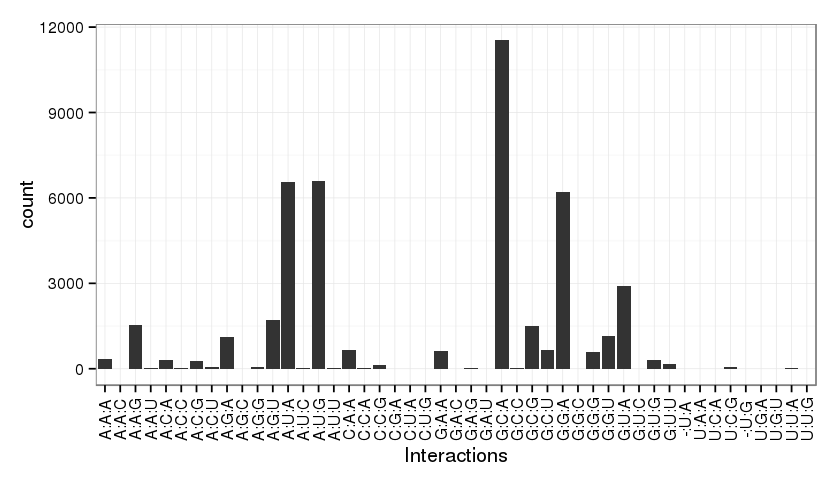

In [9]:
df$Interactions = paste0(df$X9, ':', df$X12, ':', df$X23)
ggplot(df[df$quality & !df$restrict, ], aes(x=Interactions)) + geom_histogram() + theme(axis.text.x=element_text(angle=90, vjust=0.5))

This is different from 8-14-21, in that there's a significant amount of other combinations. The "canonical" combination here is A:U:A. Here's [Gautheret et al. (1995)](http://dx.doi.org/10.1006/jmbi.1995.0200) found from looking at the Sprinzl 1991 database: ![9-12-23 frequency matrix](figures/9-12-23-gautheret.png)
And here's ours:

In [10]:
table(paste0(df[df$quality & !df$restrict, ]$X12, ':', df[df$quality & !df$restrict, ]$X23), df[df$quality & !df$restrict, ]$X9)

     
          -     A     C     G     U
  A:A     0   337   661   635     5
  A:C     0     1     0     1     0
  A:G     0  1541     0    10     0
  A:U     0    16     0     5     0
  C:A     0   316    29 11533     8
  C:C     0    11     0    18     0
  C:G     0   271   145  1494    47
  C:U     0    51     0   653     0
  G:A     0  1118     8  6224     2
  G:C     0     1     0     3     0
  G:G     0    64     0   595     0
  G:U     0  1709     0  1138     3
  U:A     1  6547     6  2909    19
  U:C     0    32     0     9     0
  U:G     1  6610     1   310     9
  U:U     0    39     0   169     0

Very, very different - there are compositional differences between Sprinzl and our quality set, in that this analysis only contains eukaryotes while Sprinzl 1991 has a lot of bacteria, archaea, and viruses. 

Again, it's useful to look at this by isotype.

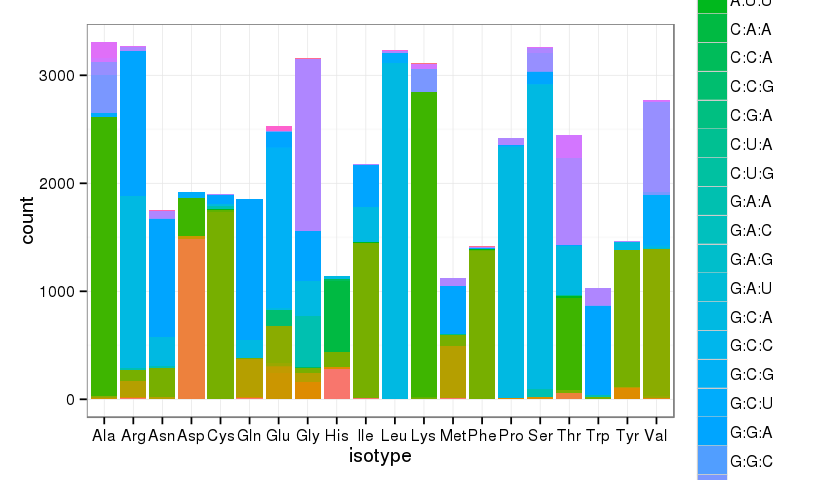

In [11]:
ggplot(df[!df$restrict & df$quality, ], aes(x=isotype, fill=Interactions)) + geom_bar()

Clearly, $3^4$ combinations is too many colors to display, so I'll filter it by the 10 most common. But this also points to the inherent stochasticity of the 9-12-23 interaction - especially interesting since 12:23 should be WC paired.

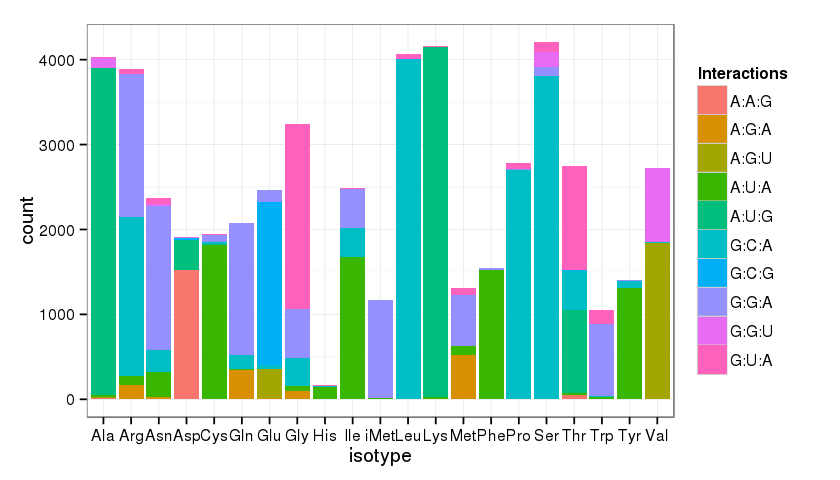

In [12]:
df2 = df %>% filter(quality | !restrict) %>% group_by(Interactions) %>% filter(n() >= 1000)
ggplot(df2, aes(x=isotype, fill=Interactions)) + geom_bar()

Even with a ridiculous cutoff of 1000+ tRNAs per triple, we still see a surprising amount of variability. It's not very convincing that this is a conserved tertiary interaction.

As always, it is good to check whether these triples are isotype-specific.

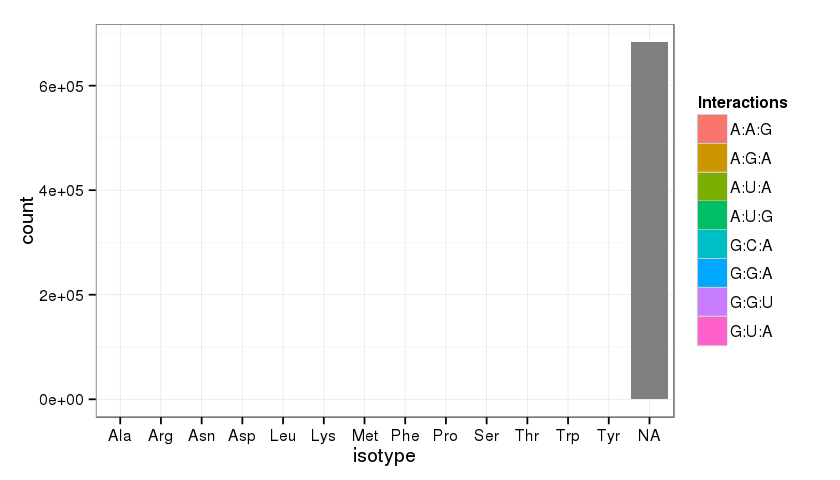

In [25]:
# filter to 1 per species
df3 = df2[!duplicated(df[, c("species", "isotype")]), ]
df3 = df3[!is.na(df3), ]
ggplot(df3, aes(x=isotype, fill=Interactions)) + geom_bar()
#chisq.test(table(df3$Interactions, droplevels(df3$isotype)))

In [21]:
nrow(df3)

[1] 2754